In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools")
import plotTools as ptools
import mplhep

In [3]:
f_sig = "skimmed_signal_v2_2018_aEM.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    "QCD":"skimmed_bkg_2018_QCD_TuneCP5_PSWeights.coffea",
    "Top":"skimmed_bkg_2018_Top.coffea",
    "DY":"skimmed_bkg_2018_DY.coffea",
    "Diboson":"skimmed_bkg_2018_Diboson.coffea",
    "Triboson":"skimmed_bkg_2018_Triboson.coffea",
    "W+jets":"skimmed_bkg_2018_WJets.coffea",
    "Z+jets":"skimmed_bkg_2018_ZJets.coffea"
}
bkg_histos = {}
histograms = []
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['W+jets'][h]) == hist.Hist and bkg_histos['W+jets'][h].sum(flow=True).value > 0:
        bkg[h] = {b:bkg_histos[b][h][{"samp":sum}] for b in bkg_histos.keys()}

In [4]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
all_ctaus = sorted(list(set(si.ctau)))

In [20]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
def plot(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,cut="cut7",nameVar="",flow=False):
    flow_str = "show" if flow else "none"
    
    bkg_stack = {b:bkg[hname][b] for b in bkg_histos.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    print(avail_cuts)
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)
    varAx = hb.axes[-1]
    for delta in deltas:
        fig,axes = plt.subplots(1,len(all_ctaus),figsize=(len(all_ctaus)*6,4))
        
        # plot bkgs
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,all_ctaus[i]))
            hb.plot(stack=True,yerr=False,density=False,histtype='fill',color=[k for k in mpl.colormaps['Set3'].colors][:nb])
            if i==0:
                ncol = 2
                plt.legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=10,ncol=ncol)
        
        # plot signals
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for j,m1 in enumerate(m1s):
            ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
            for i,ct in enumerate(all_ctaus):
                if ct not in ctaus:
                    continue
                plt.sca(axes[i])
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
        
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            if logy:
                plt.yscale('log')
            if not flow:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            if i==1:
                ncol = 2
                leg_entries = [Line2D([0],[0],color=f"C{j}",label=r"$M_1 = {0}$".format(m1s[j])) for j in range(len(m1s))]                    
                plt.gca().legend(handles=leg_entries,loc='upper center',bbox_to_anchor=(0.5,1),fontsize=10,ncol=ncol)
        
        #plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        outDir = f"plots/histos/{cut}/sig_vs_bkg/{hname}{nameVar}/delta_{delta:.1f}/"
        outName = f"ct-all.pdf"
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        #plt.tight_layout()
        #plt.savefig(f"{outDir}/{outName}")
        
        # new figures split up by ctau
        ctaus = sorted(list(set(si[(si.delta==delta)].ctau)))
        for ct in ctaus:
            plt.figure(figsize=(8,6))
            hb.plot(stack=True,yerr=False,density=False,histtype='fill',color=[k for k in mpl.colormaps['Set3'].colors][:nb])
            m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
            for k,m1 in enumerate(m1s):
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{k}",ax=plt.gca(),flow=flow_str)
            if logy:
                plt.yscale('log')
            if not flow:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            ncol = 3
            plt.legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=12,ncol=ncol)
            plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
            #plt.tight_layout()
            outName = f"ct-{ct}.pdf"
            #plt.savefig(f"{outDir}/{outName}")
            plt.close()
            
def plotSignal(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,cut="cut7",nameVar="",flow=False):
    flow_str = "show" if flow else "none"
    for delta in deltas:
        fig,axes = plt.subplots(1,len(all_ctaus),figsize=(len(all_ctaus)*6,4))
        # plot signals
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for j,m1 in enumerate(m1s):
            ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
            for i,ct in enumerate(all_ctaus):
                if ct not in ctaus:
                    continue
                plt.sca(axes[i])
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
        
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            if logy:
                plt.yscale('log')
            if not flow:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            if i==1:
                ncol = 2
                leg_entries = [Line2D([0],[0],color=f"C{j}",label=r"$M_1 = {0}$".format(m1s[j])) for j in range(len(m1s))]                    
                plt.gca().legend(handles=leg_entries,loc='upper center',bbox_to_anchor=(0.5,1),fontsize=10,ncol=ncol)
        
        #plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        outDir = f"plots/histos/{cut}/sig_vs_bkg/{hname}{nameVar}/delta_{delta:.1f}/"
        outName = f"ct-all.pdf"
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        #plt.tight_layout()
        #plt.savefig(f"{outDir}/{outName}")

## Isolation

{'QCD': ['cut7'], 'Top': ['cut7', 'cut12'], 'DY': ['cut7', 'cut12'], 'Diboson': ['cut7', 'cut12'], 'Triboson': ['cut7', 'cut12'], 'W+jets': ['cut7', 'cut12'], 'Z+jets': ['cut7', 'cut12']}


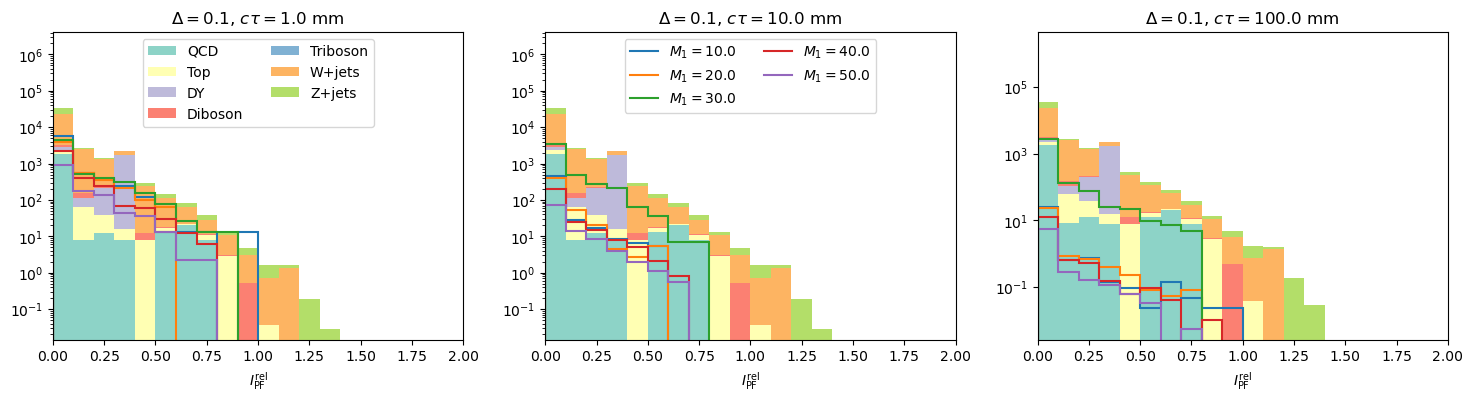

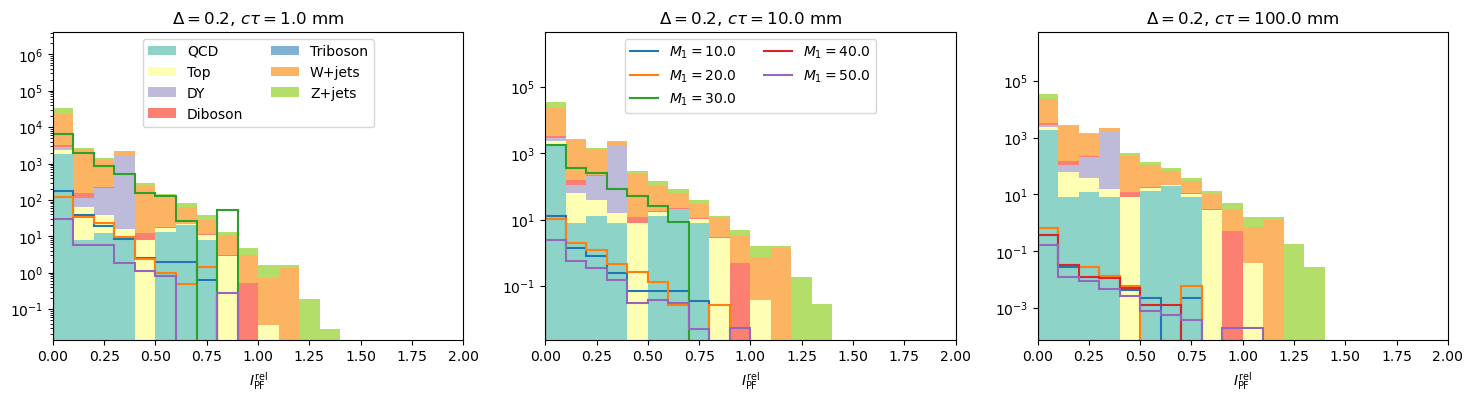

In [11]:
# vertex max PF isolation, using official PFIso for the electrons
plot("sel_vtx_maxPFIso",[0,2],logy=True,rebin=1j,xlabel="$I_\mathrm{PF}^\mathrm{rel}$",scaley=60,cut="cut7")

## Displacement

{'QCD': ['cut7'], 'Top': ['cut7', 'cut12'], 'DY': ['cut7', 'cut12'], 'Diboson': ['cut7', 'cut12'], 'Triboson': ['cut7', 'cut12'], 'W+jets': ['cut7', 'cut12'], 'Z+jets': ['cut7', 'cut12']}


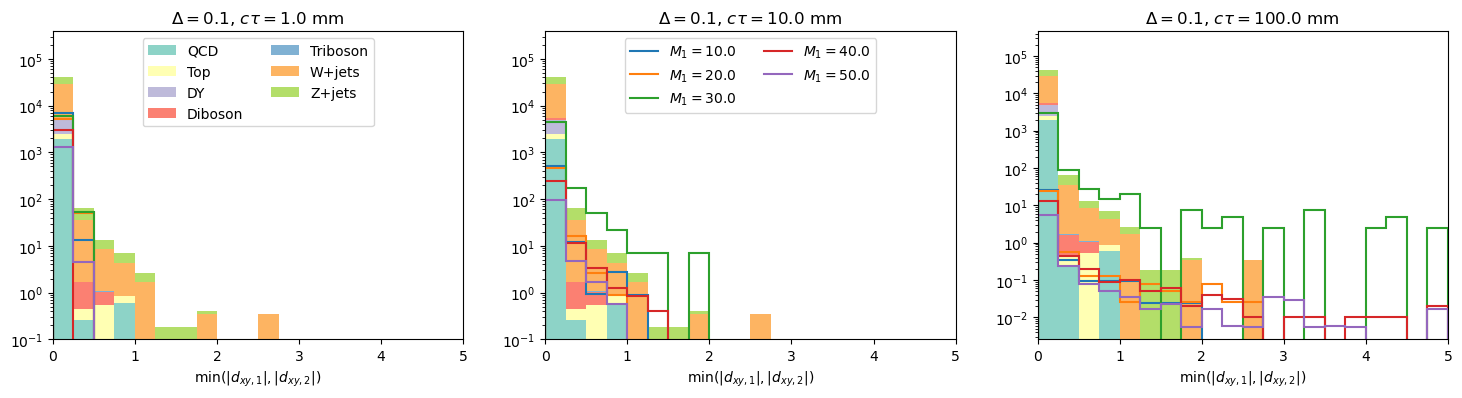

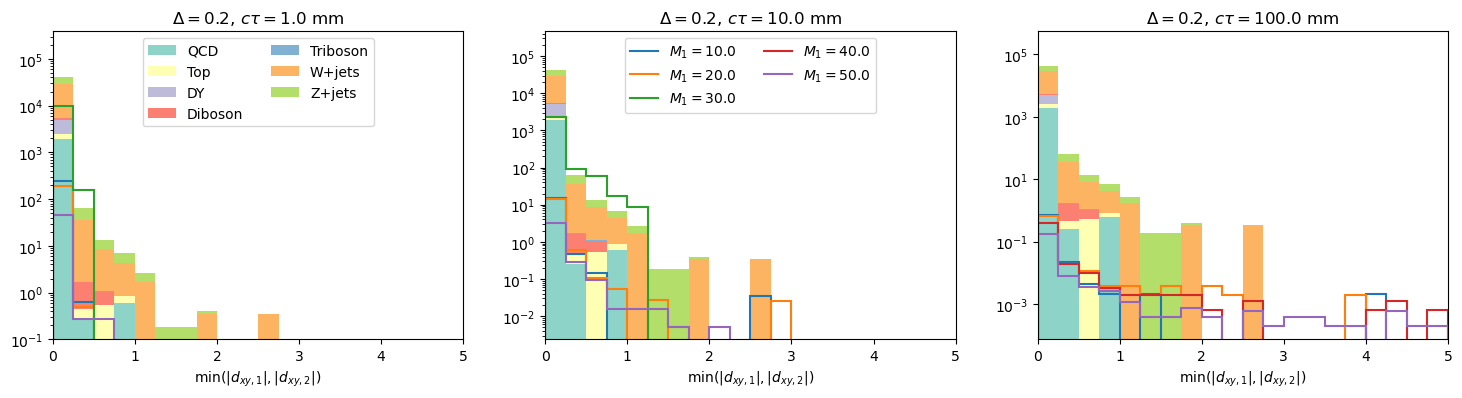

In [12]:
# vertex min(dxy1,dxy2)
plot("sel_vtx_minDxy",[0,5],logy=True,rebin=25j,xlabel="$\min(|d_{xy,1}|,|d_{xy,2}|)$",cut="cut7")

{'QCD': ['cut7'], 'Top': ['cut7', 'cut12'], 'DY': ['cut7', 'cut12'], 'Diboson': ['cut7', 'cut12'], 'Triboson': ['cut7', 'cut12'], 'W+jets': ['cut7', 'cut12'], 'Z+jets': ['cut7', 'cut12']}


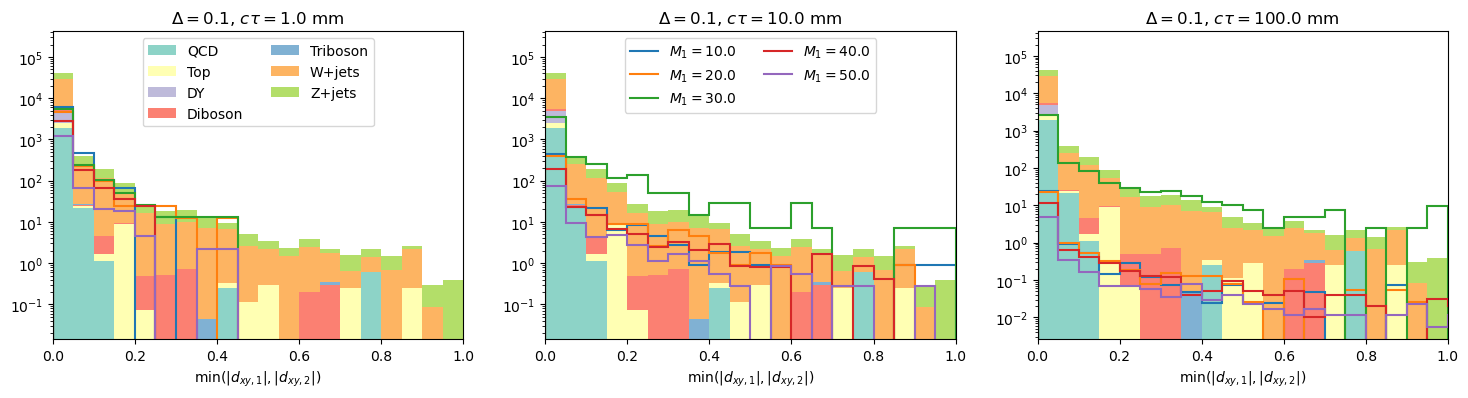

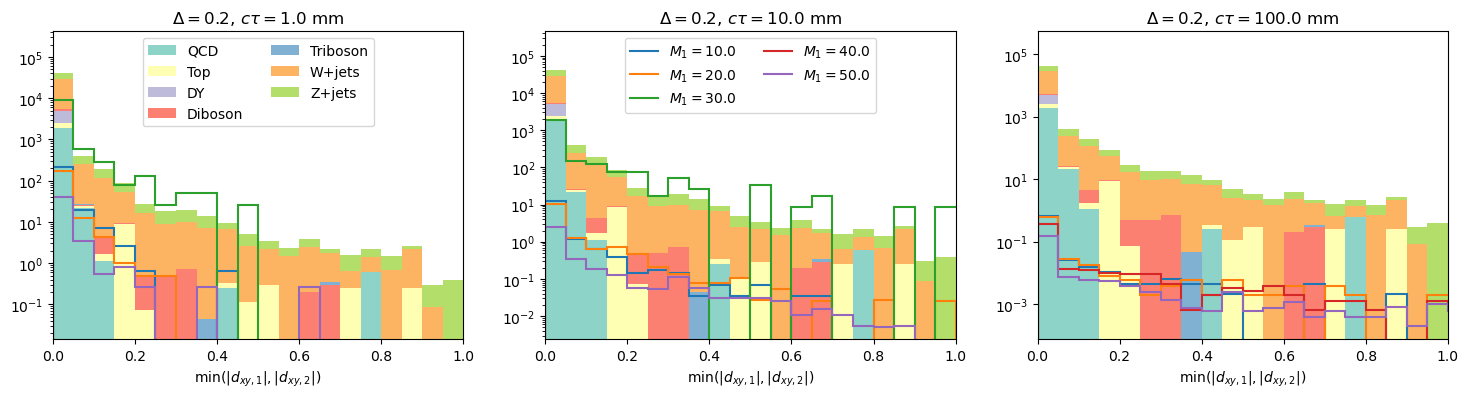

In [13]:
# vertex min(dxy1,dxy2)
plot("sel_vtx_minDxy",[0,1],logy=True,rebin=5j,xlabel="$\min(|d_{xy,1}|,|d_{xy,2}|)$",cut="cut7",nameVar='_zoom')

{'QCD': ['cut7'], 'Top': ['cut7', 'cut12'], 'DY': ['cut7', 'cut12'], 'Diboson': ['cut7', 'cut12'], 'Triboson': ['cut7', 'cut12'], 'W+jets': ['cut7', 'cut12'], 'Z+jets': ['cut7', 'cut12']}


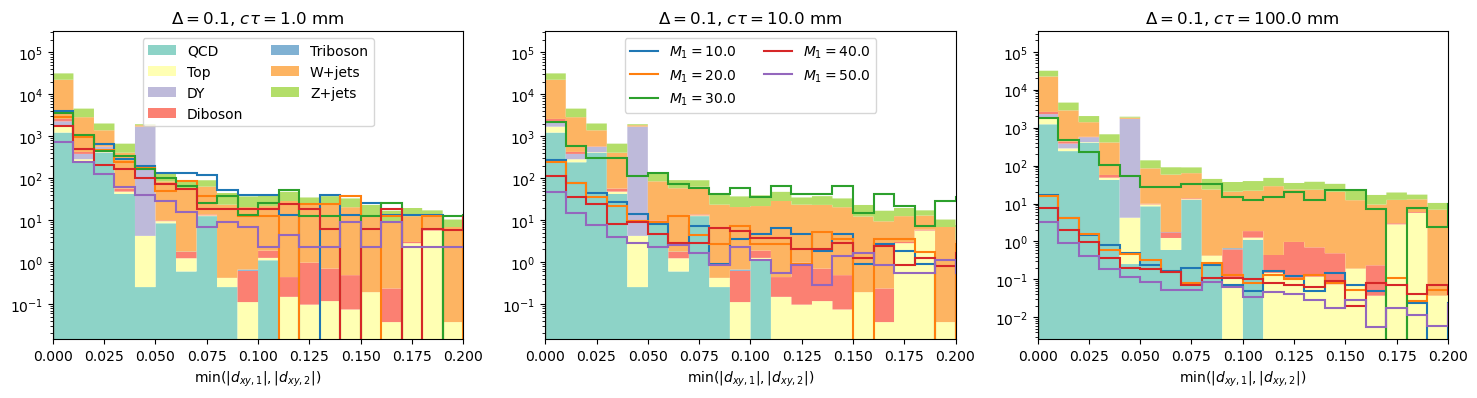

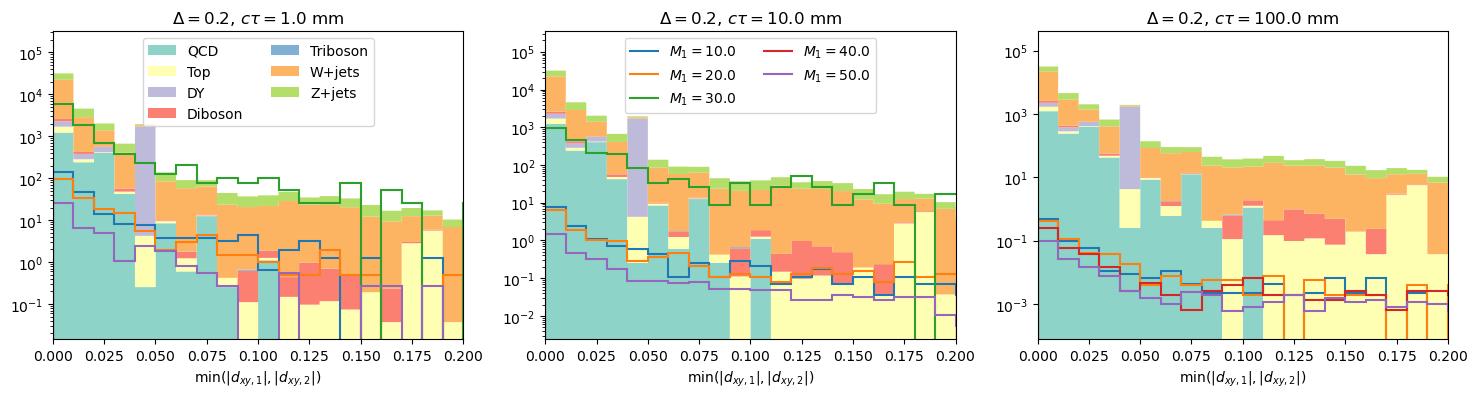

In [14]:
# vertex min(dxy1,dxy2)
plot("sel_vtx_minDxy",[0,0.2],logy=True,rebin=1j,xlabel="$\min(|d_{xy,1}|,|d_{xy,2}|)$",cut="cut7",nameVar='_zoomzoom')

{'QCD': ['cut7'], 'Top': ['cut7', 'cut12'], 'DY': ['cut7', 'cut12'], 'Diboson': ['cut7', 'cut12'], 'Triboson': ['cut7', 'cut12'], 'W+jets': ['cut7', 'cut12'], 'Z+jets': ['cut7', 'cut12']}


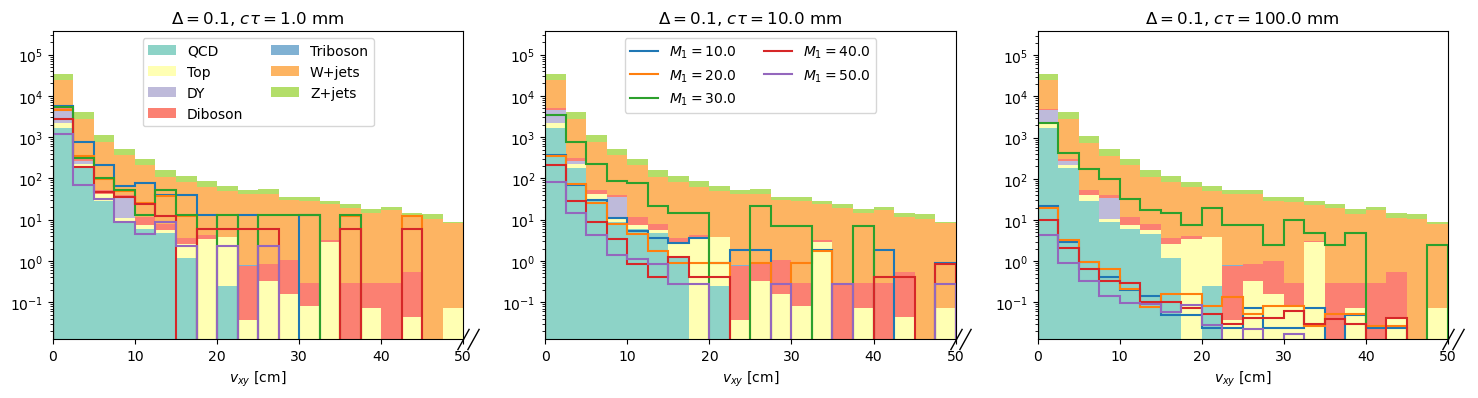

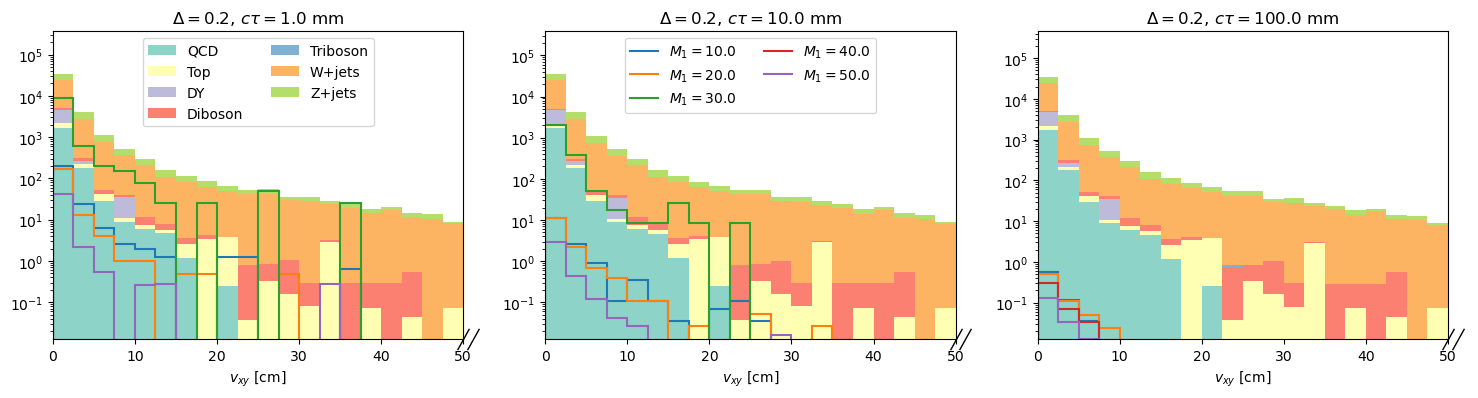

In [15]:
# vertex vxy
plot("sel_vtx_vxy",[0,50],logy=True,rebin=100j,cut="cut7")

## Vertex dR

{'QCD': ['cut7'], 'Top': ['cut7', 'cut12'], 'DY': ['cut7', 'cut12'], 'Diboson': ['cut7', 'cut12'], 'Triboson': ['cut7', 'cut12'], 'W+jets': ['cut7', 'cut12'], 'Z+jets': ['cut7', 'cut12']}


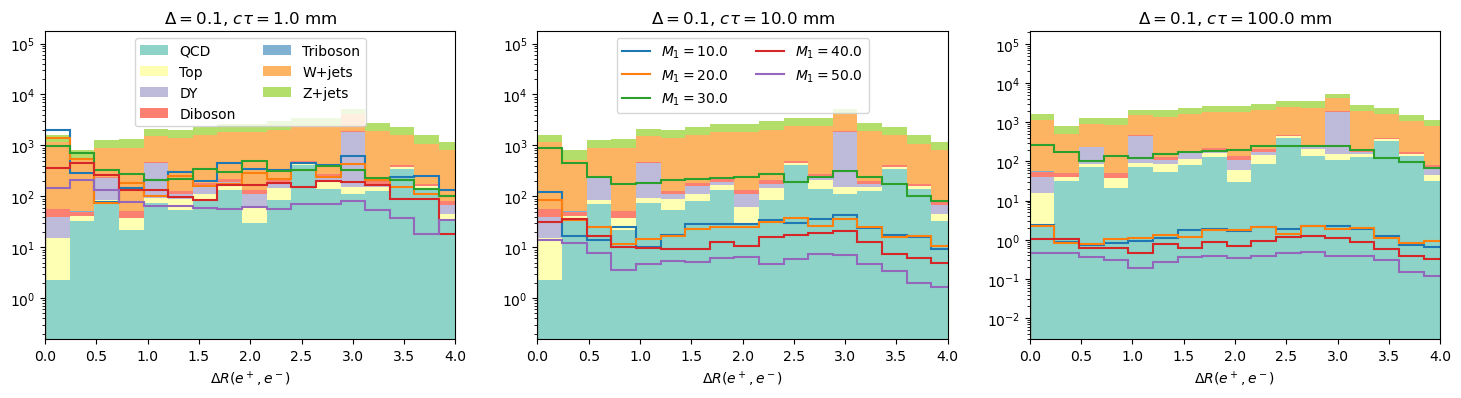

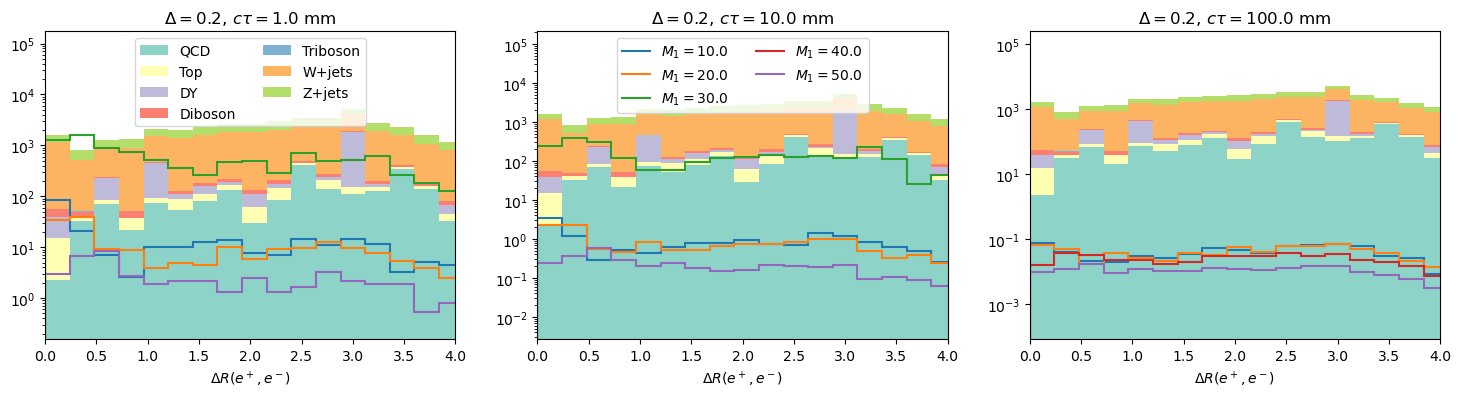

In [16]:
# vertex dR
plot("sel_vtx_dR",[0,4],logy=True,rebin=4j,xlabel="$\Delta R(e^+,e^-)$",scaley=20,cut="cut7")

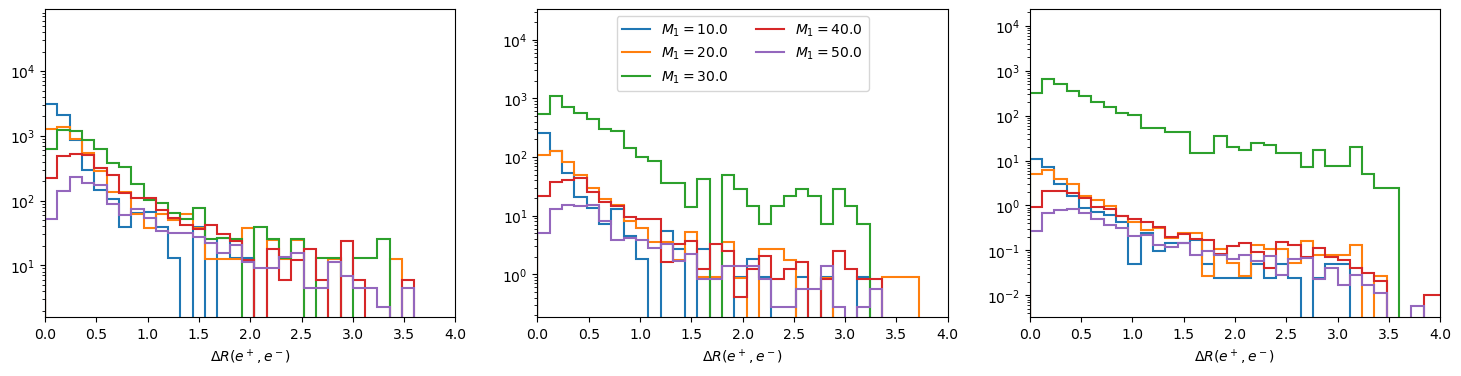

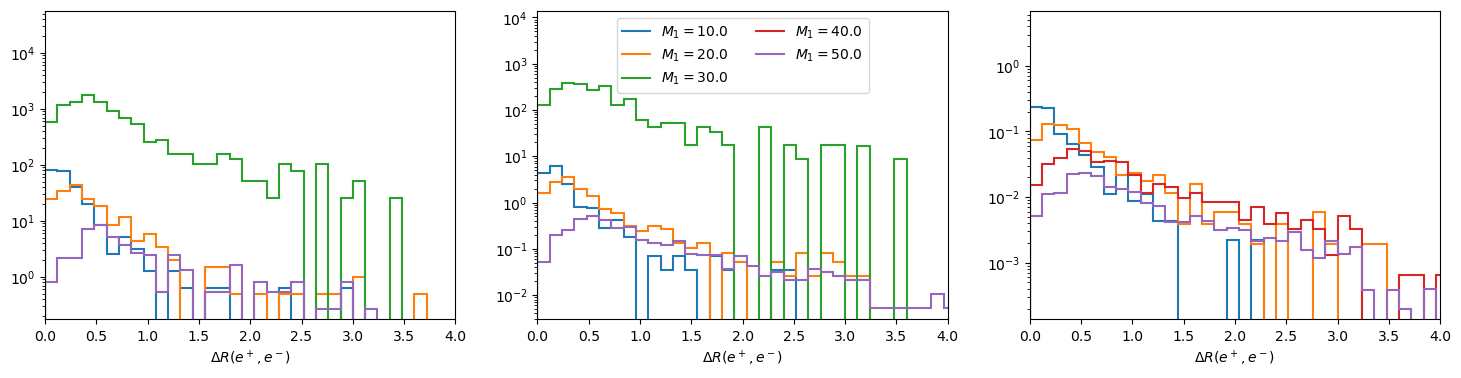

In [22]:
# vertex dR
plotSignal("genEE_dR",[0,4],logy=True,rebin=2j,xlabel="$\Delta R(e^+,e^-)$",scaley=20,cut="cut7")

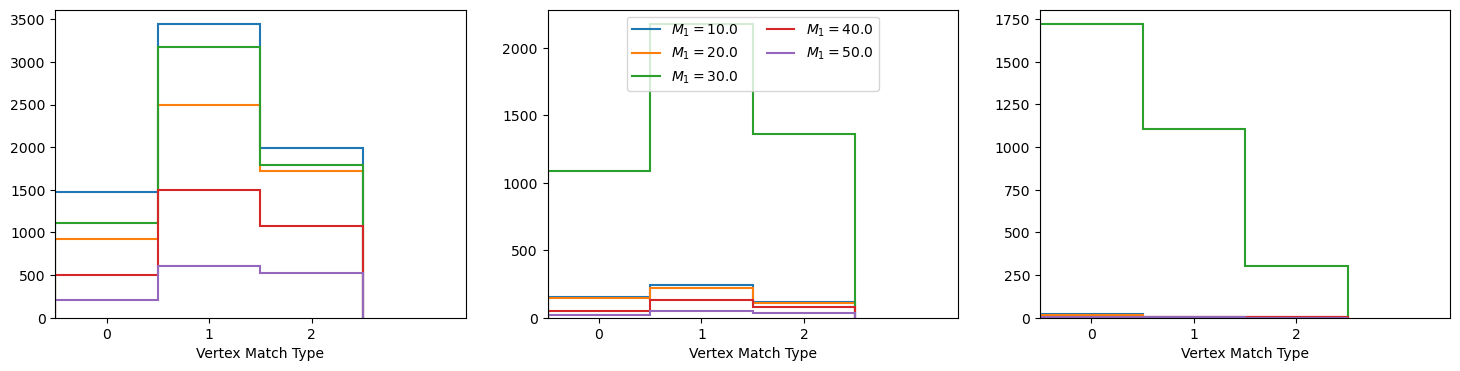

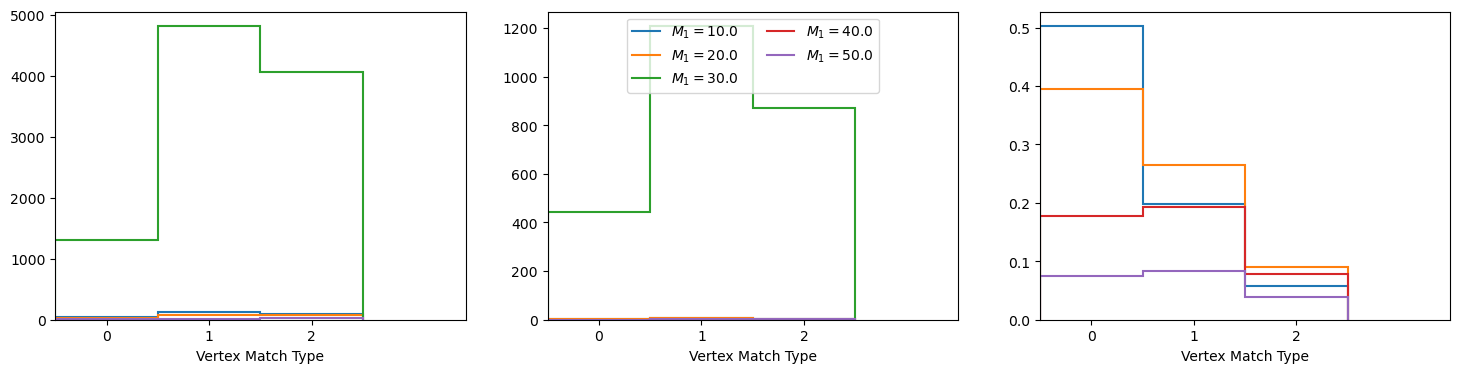

In [25]:
# vertex match type
plotSignal("sel_vtx_matchType",[0,4],logy=False,xlabel="Vertex Match Type",scaley=1,cut="cut7")

## Vertex-MET dPhi

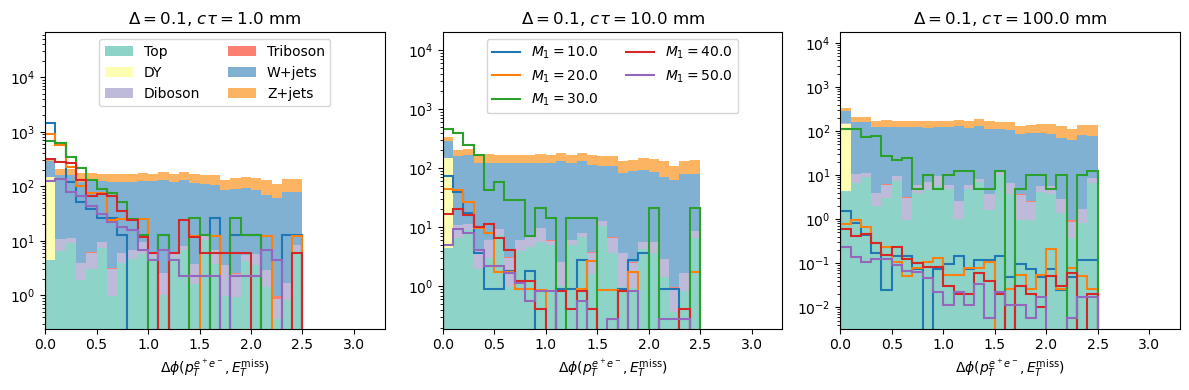

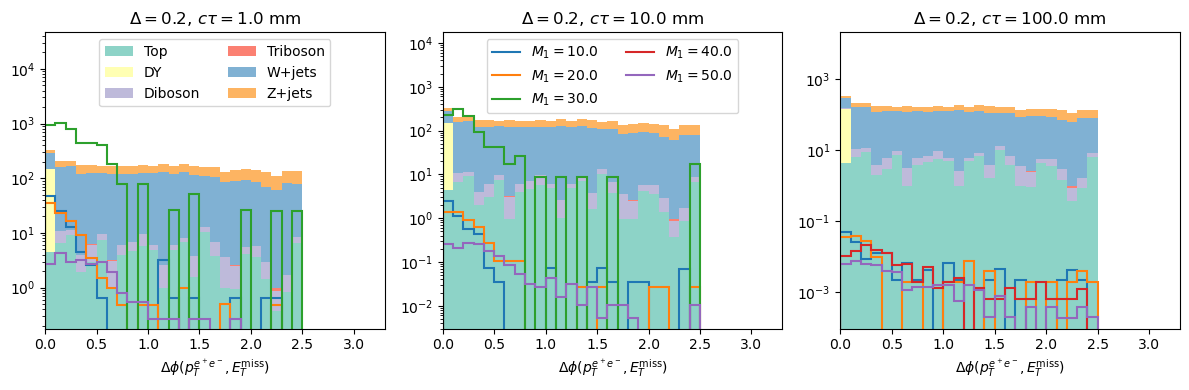

In [9]:
# vertex MET dPhi
plot("vtx_met_dPhi",[0,3.3],logy=True,rebin=2j,xlabel=r"$\Delta \phi(p_T^{e^+e^-},E_T^\mathrm{miss})$",scaley=30,cut="cut7")

## Vertex Chi2

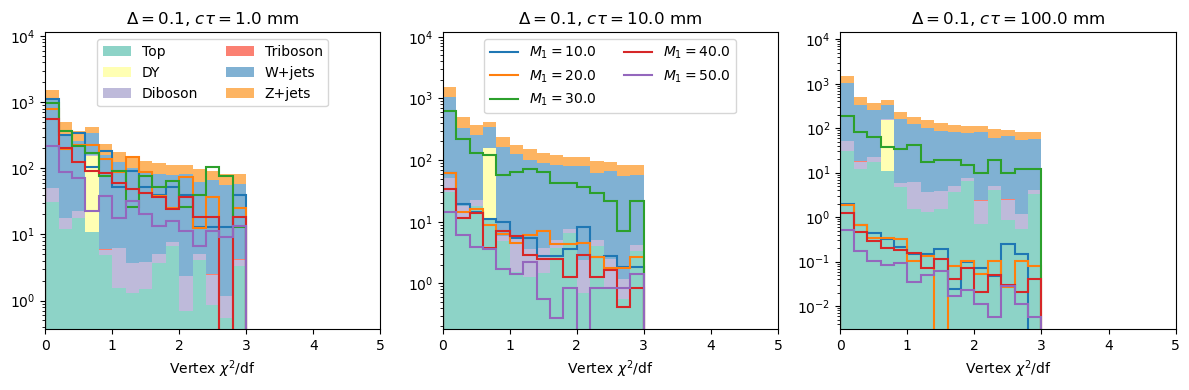

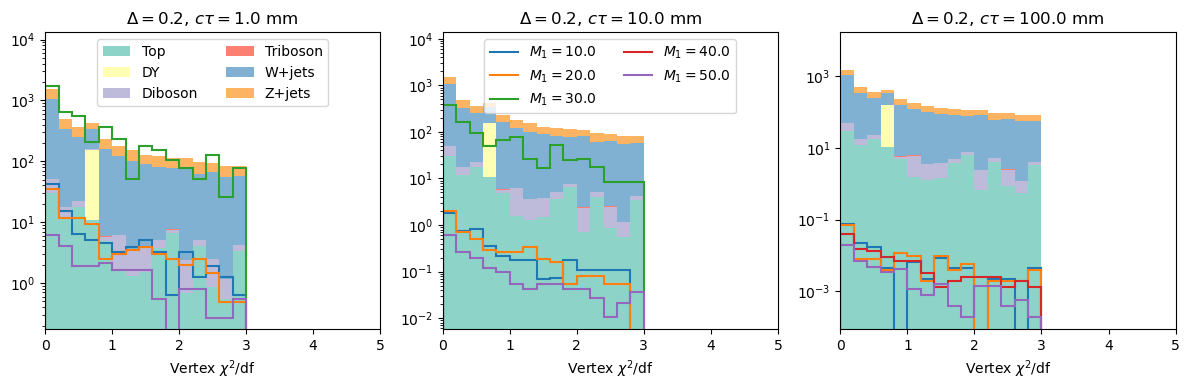

In [10]:
# vertex chi2
plot("sel_vtx_chi2",[0,5],logy=True,rebin=1j,xlabel="Vertex $\chi^2/\mathrm{df}$",cut="cut7")

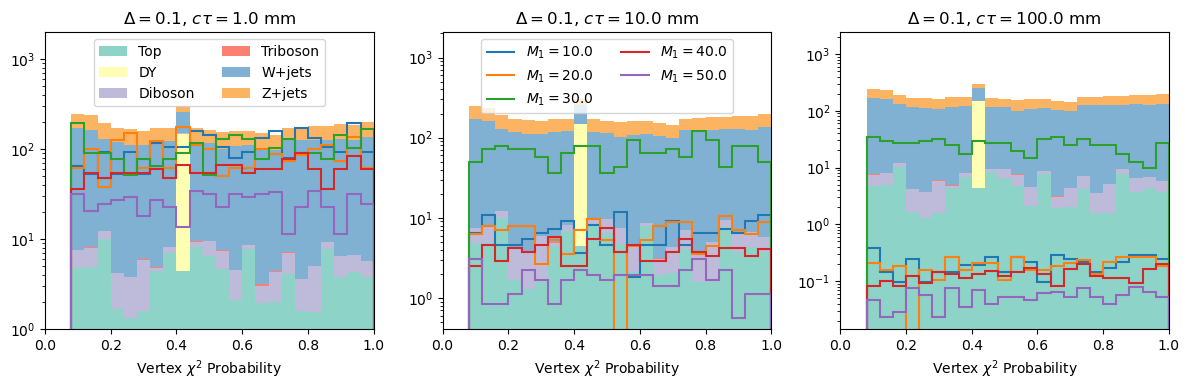

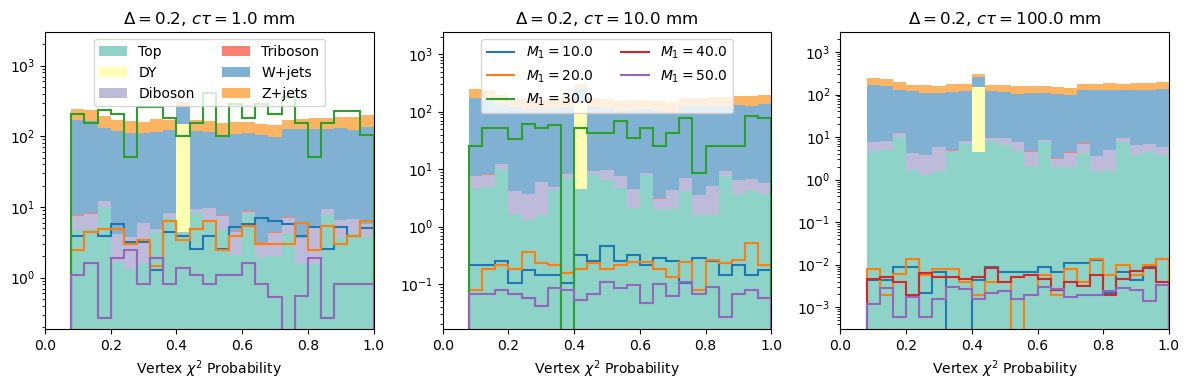

In [11]:
# vertex prob
plot("sel_vtx_prob",[0,1],logy=True,rebin=4j,cut="cut7")

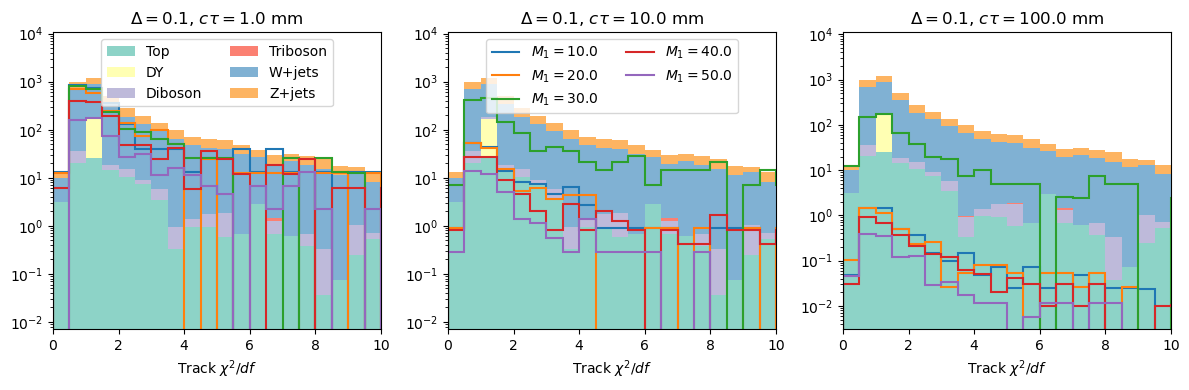

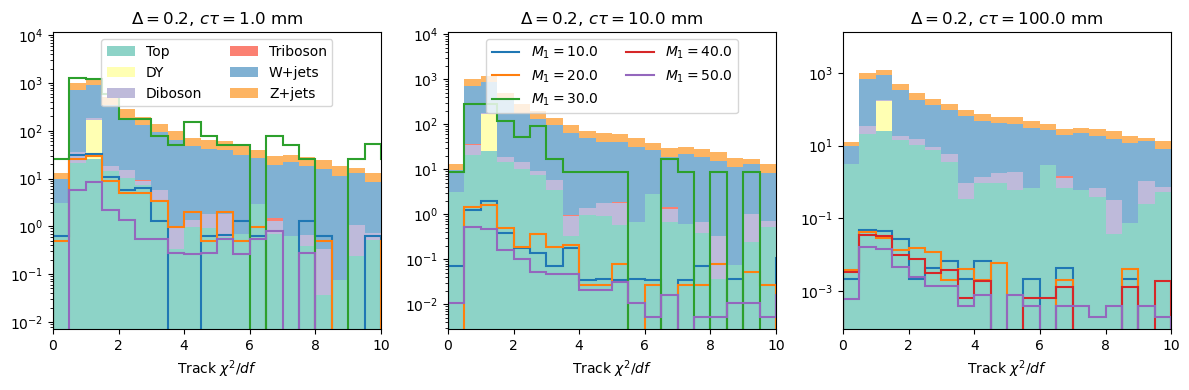

In [12]:
# vertex max(e1_chi2,e2_chi2)
plot("sel_vtx_max_chi2",[0,10],logy=True,rebin=1j,cut="cut7")

## Electron-jet dR

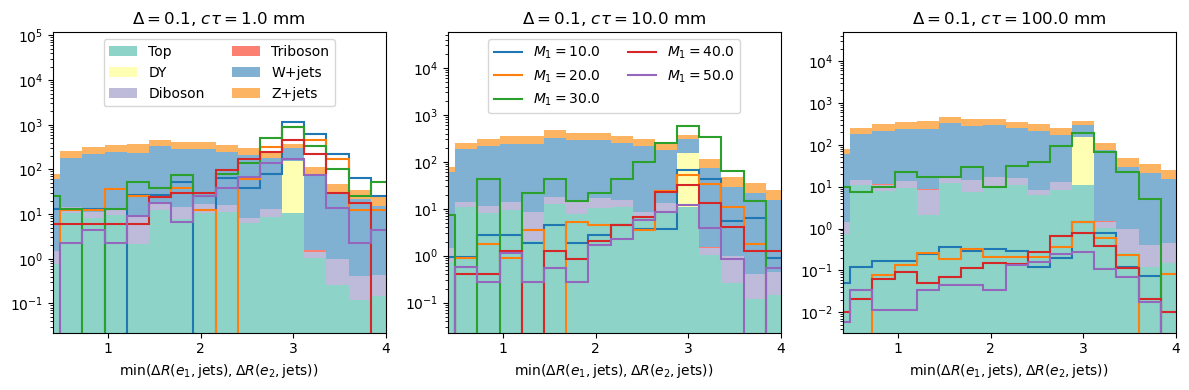

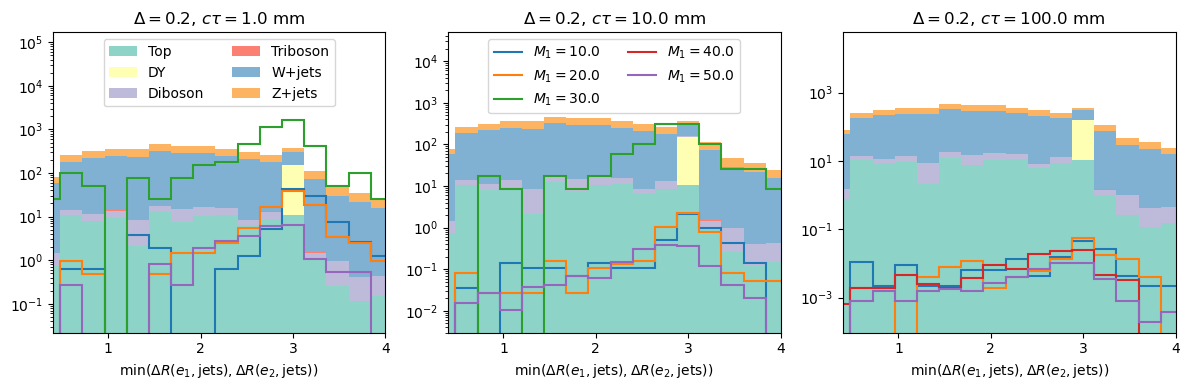

In [13]:
# mindR(vtx_eles,jets)
plot("sel_vtx_minEledRj",[0.4,4],logy=True,rebin=4j,scaley=60,xlabel="$\min(\Delta R(e_1,\mathrm{jets}),\Delta R(e_2,\mathrm{jets}))$",cut="cut7")

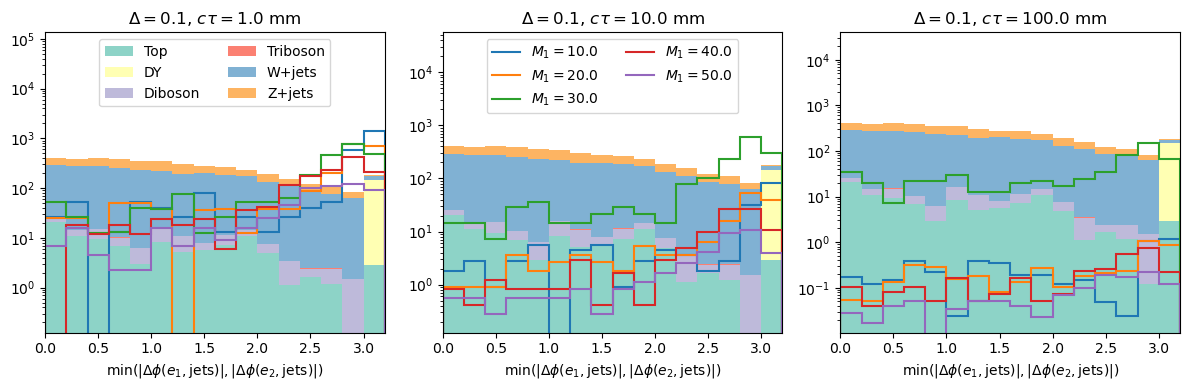

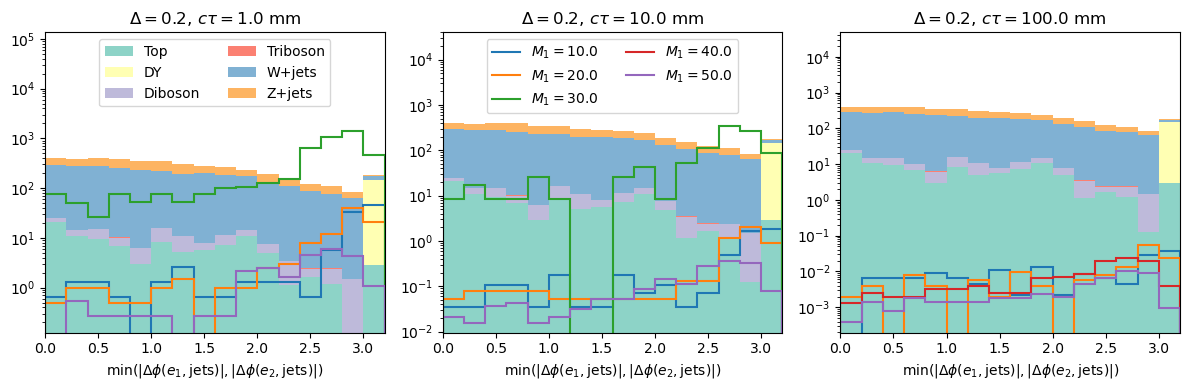

In [14]:
# mindPhi(vtx_eles,jets)
plot("sel_vtx_minEledPhiJ",[0,3.2],logy=True,rebin=2j,scaley=60,xlabel="$\min(|\Delta \phi(e_1,\mathrm{jets})|,|\Delta \phi(e_2,\mathrm{jets})|)$",cut="cut7")

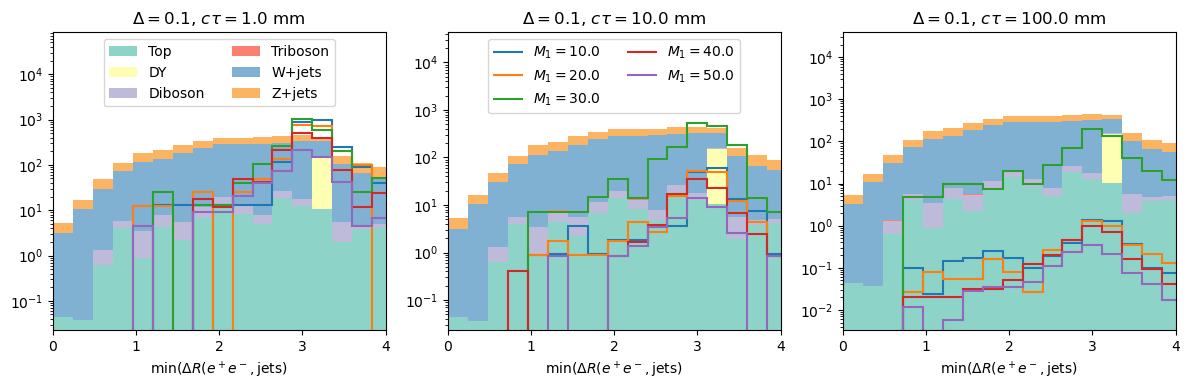

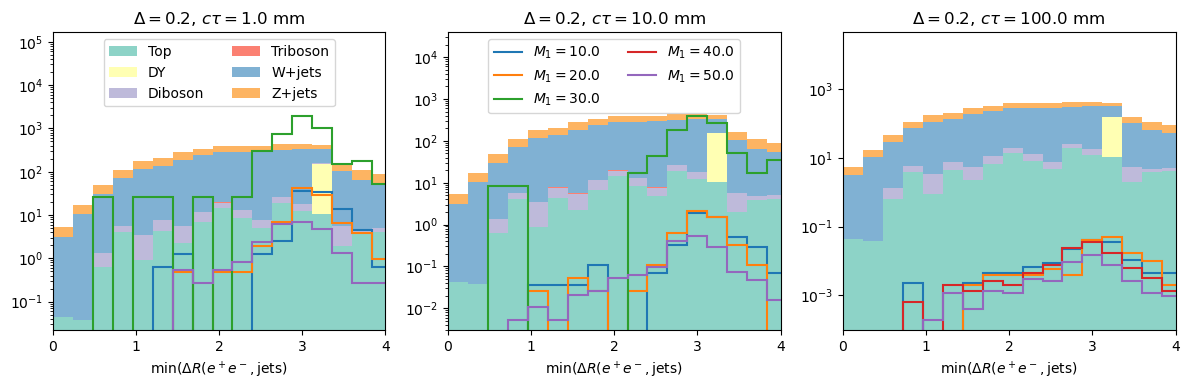

In [15]:
# mindR(vtx,jets)
plot("sel_vtx_mindRj",[0,4],logy=True,rebin=4j,scaley=50,xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets})$",cut="cut7")

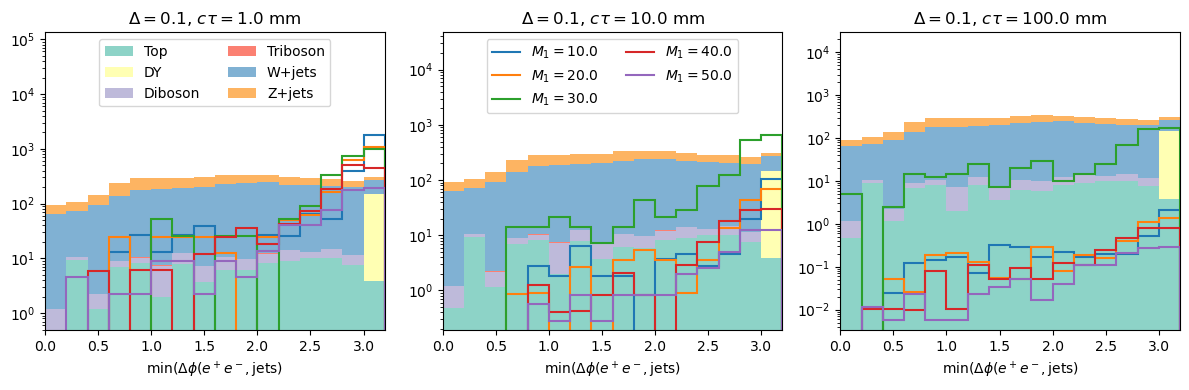

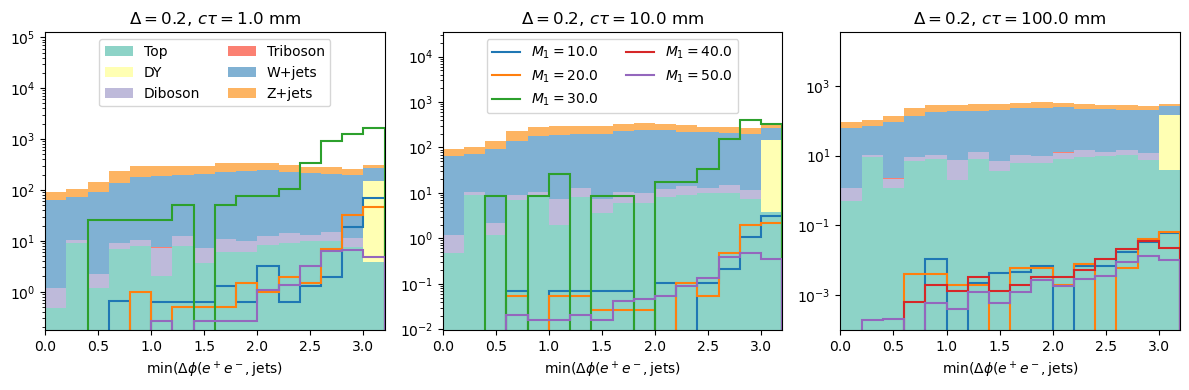

In [16]:
# mindPhi(vtx,jets)
plot("sel_vtx_mindPhiJ",[0,3.2],logy=True,rebin=2j,scaley=50,xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets})$",cut="cut7")